In [59]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

print(tf.__version__)

2.9.0


In [60]:
tf.config.run_functions_eagerly(True)

In [61]:
tf.config.list_physical_devices('GPU')

[]

In [62]:
data_news_headlines = pd.read_json("../shared_data/x1.json")

# Adjust news headline data
data_news_headlines = data_news_headlines.drop(columns='article_link', axis=1)
data_news_headlines = data_news_headlines.rename(columns ={'headline':'text', 'is_sarcastic':'label'})
data_news_headlines = data_news_headlines.reindex(columns=['text','label'])
data_news_headlines.head()

,text,label
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [63]:
data_tweets = pd.read_csv("../shared_data/dataset_csv.csv")

# Adjust tweets data
data_tweets = data_tweets.rename(columns={'tweets':'text'})
data_tweets.head()

,text,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [64]:
data_sitcoms = pd.read_csv("../shared_data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [65]:
data_reddit = pd.read_csv("../shared_data/train-balanced-sarcasm.csv")

# Adjust reddit data
data_reddit = data_reddit.drop(columns=['author','subreddit','score','ups','downs','date','created_utc','parent_comment'], axis=1)
data_reddit = data_reddit.rename(columns={'comment':'text'})
data_reddit = data_reddit.reindex(columns=['text','label'])

data_reddit.head()

,text,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme isn't funny none of the ""new york ni...",0
4,I could use one of those tools.,0


In [66]:
# Combine all 4 datasets
data = pd.concat([data_news_headlines,data_tweets,data_sitcoms,data_reddit], ignore_index=True)

# remove non string (nan) rows
for index, row in data.iterrows():
    if not type(row['text']) == str:
        data = data.drop(index, axis='index')

# Shuffle the rows
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,text,label
0,"Hair up, glasses off.",0.0
1,"So many references tonight, it's glorious!",0.0
2,You could use XModGames and get TMI on it,0.0
3,I'm glad you figured out to put it on your lap...,1.0
4,did anyone else hear the cans crunching?,0.0


Set dataset and training variables

In [67]:
subset_size = 1400
testing_size = int(subset_size * 0.4)
validation_size = int(subset_size * 0.2)
shuffle_size = subset_size - validation_size

data_batch_size = 32

In [68]:
data = data.sample(frac=1).reset_index(drop=True)
train_data = data.head(subset_size)
test_data = data.head(testing_size)

In [69]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][validation_size:], 
        train_data['label'][validation_size:]
    )
).shuffle(shuffle_size).batch(data_batch_size)

val_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][:validation_size],
        train_data['label'][:validation_size]
    )
).batch(data_batch_size)

test_ds = tf.data.Dataset.from_tensor_slices(
    (
        test_data['text'],
        test_data['label']
    )
)

Set training variables

In [70]:
epochs = 400
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

Download Preprocessing and Encoding Model Layers from TensorflowHub

In [71]:
preprocessing_layer = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', 
    name='preprocessing'
)

bert_encoder = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1', 
    trainable=True, 
    name='BERT_encoder'
)

Create the model using, the BERT encoder

In [72]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessing_layer(text_input)
    outputs = bert_encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

Sanity check of model (untrained result)

In [73]:

text_test = ["Please, keep talking. I always yawn when I am interested."]
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.51009357]], shape=(1, 1), dtype=float32)


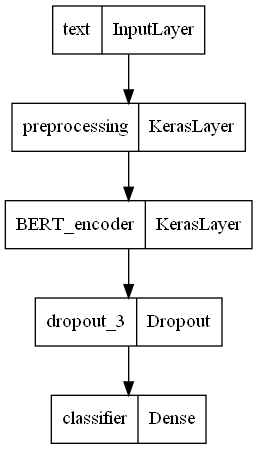

In [74]:
tf.keras.utils.plot_model(classifier_model)

Set loss function

In [75]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

Create the optimizer

In [76]:
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

Compile the model

In [77]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Train the model

In [78]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/400
35/35 [==============================] - 148s 4s/step - loss: 0.7239 - binary_accuracy: 0.4973 - val_loss: 0.7215 - val_binary_accuracy: 0.5071
Epoch 2/400
35/35 [==============================] - 139s 4s/step - loss: 0.7070 - binary_accuracy: 0.5134 - val_loss: 0.7121 - val_binary_accuracy: 0.5071
Epoch 3/400
35/35 [==============================] - 137s 4s/step - loss: 0.6954 - binary_accuracy: 0.5214 - val_loss: 0.7060 - val_binary_accuracy: 0.5179
Epoch 4/400
35/35 [==============================] - 137s 4s/step - loss: 0.6875 - binary_accuracy: 0.5179 - val_loss: 0.6994 - val_binary_accuracy: 0.5143
Epoch 5/400
35/35 [==============================] - 143s 4s/step - loss: 0.6797 - binary_accuracy: 0.5375 - val_loss: 0.6929 - val_binary_accuracy: 0.5429
Epoch 6/400
35/35 [==============================] - 147s 4s/step - loss: 0.6512 - binary_accuracy: 0.5821 - val_loss: 0.6859 - val_binary_accuracy: 0.5286
Epoch 7/400
35/35 [==============================] - 157s 5s/ste

Test the model

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Plot the accuracy and loss over time

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Export for inference

In [ ]:
saved_model_path = './model_saves/bert_v1/'
classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./model_saves/bert_v1/assets


INFO:tensorflow:Assets written to: ./model_saves/bert_v1/assets


Reload and test inference

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  for i in range(len(inputs)):
    print('input: ', inputs[i], ' : score: ', results[i][0], ' : rounded: ', round(results[i][0]))
  print()


examples = [
    "Please, keep talking. I always yawn when I am interested.", # expect 1
    "Well, what a surprise.", # expect 1
    "Really, Sherlock? No! You are clever.", # expect 1
    "The quick brown fox jumps over the lazy dog", # expect 0
    "Numerous references to the phrase have occurred in movies, television, and books." # expect 0
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:


AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      